In [1]:
import torch
import json
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# Dataset config
with open("../../config/config.json") as json_file:
    config = json.load(json_file)
    TIME_BEG = config["dataset"]["begin_timestamp"]
    # TIME_BEG = 1451606420 # = year 2016
    # TIME_BEG = 1546347600 # = year 2019
    TIME_INTERVAL = config["dataset"]["time_interval"] // 60 # minutes
    LEN_ENCODE_SERIE = config["model"]["len_encode_serie"]
    LEN_DECODE_SERIE = config["model"]["len_decode_serie"]
    print("Time interval: ", TIME_INTERVAL)
    print("Encode serie length: ", LEN_ENCODE_SERIE)
    print("Decode serie length: ", LEN_DECODE_SERIE)
    

Time interval:  60
Encode serie length:  24
Decode serie length:  1


In [3]:
# Read csv file
prices = None
with open('kaggle_1min.csv', 'r') as f:
    reader = csv.reader(f)
    prices = list(reader)

In [4]:
# Process with Panda dataframe
prices_df = pd.DataFrame(prices[1:], columns=prices[0])
print("Original dataframe: ", prices_df)

prices_df = prices_df.drop(columns=["Volume_(Currency)"])
prices_df = prices_df.astype(float)
prices_df = prices_df.fillna(0) # Replace NaN with 0 (time where trade volume = 0)
prices_df = prices_df.loc[prices_df["Timestamp"] >= TIME_BEG] # Cut off from desired begin time
prices_df = prices_df.reset_index(drop=True)

# Make col name to index map
cols = prices_df.columns
col_i = dict()
for i in range(len(cols)):
    col_i[cols[i]] = i

print("Processed dataframe: ", prices_df)

Original dataframe:            Timestamp      Open      High       Low     Close Volume_(BTC)  \
0        1325317920      4.39      4.39      4.39      4.39   0.45558087   
1        1325317980       NaN       NaN       NaN       NaN          NaN   
2        1325318040       NaN       NaN       NaN       NaN          NaN   
3        1325318100       NaN       NaN       NaN       NaN          NaN   
4        1325318160       NaN       NaN       NaN       NaN          NaN   
...             ...       ...       ...       ...       ...          ...   
4727772  1609372560  28801.47  28829.42  28785.64  28829.42   0.96522104   
4727773  1609372620  28829.42   28863.9  28829.42  28857.06   2.36883117   
4727774  1609372680  28850.49  28900.52  28850.49  28882.82   2.46658976   
4727775  1609372740  28910.54  28911.52   28867.6   28881.3     7.332773   
4727776  1609372800  28893.21  28928.49  28893.21  28928.49   5.75767938   

        Volume_(Currency) Weighted_Price  
0            2.00000001

In [5]:
print(col_i)

{'Timestamp': 0, 'Open': 1, 'High': 2, 'Low': 3, 'Close': 4, 'Volume_(BTC)': 5, 'Weighted_Price': 6}


In [6]:
# Convert dataframe to torch tensor
prices_tensor = torch.from_numpy(prices_df.values)

In [7]:
# Fill values for timesteps with 0 trade volume
count = 0
for i in range(0, len(prices_tensor)):
    if prices_tensor[i, col_i["Volume_(BTC)"]] == 0:
        prices_tensor[i, col_i["Open"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Close"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["High"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Low"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Weighted_Price"]] = prices_tensor[i-1, col_i["Close"]]
        count += 1
print("Filled ", str(count), " values out of ", str(len(prices_tensor)))

Filled  262441  values out of  2629440


In [8]:
# Summarize data by each TIME_INTERVAL, use Volume Weighted Average Price (VWAP)
num_data = prices_tensor.shape[0] // TIME_INTERVAL
shape = (num_data, len(col_i))
condensed_prices_tensor = torch.empty(shape)

count = 0
j = 0
i = 0
while i <= len(prices_tensor) - TIME_INTERVAL:
    condensed_prices_tensor[j, col_i["Timestamp"]] = prices_tensor[i, col_i["Timestamp"]] # Time stamp

    # Calculate WVAP
    volume_weighted_sum = torch.sum(prices_tensor[i:i+TIME_INTERVAL, col_i["Volume_(BTC)"]] * prices_tensor[i:i+TIME_INTERVAL, col_i["Weighted_Price"]])
    total_volume = torch.sum(prices_tensor[i:i+TIME_INTERVAL, col_i["Volume_(BTC)"]])
    wvap = volume_weighted_sum / total_volume
    
    # If no trade in this time interval use the price in the previous one
    # Here assume that first TIME_INTERVAL starting from TIME_BEG has non-zero trade volume
    if total_volume == 0:
        condensed_prices_tensor[j, col_i["Weighted_Price"]] = condensed_prices_tensor[j-1, col_i["Weighted_Price"]]
        count += 1
    else:
        condensed_prices_tensor[j, col_i["Weighted_Price"]] = wvap
        
    # Sum up candle stats
    condensed_prices_tensor[j, col_i["Open"]] = prices_tensor[i, col_i["Open"]] # Open price 
    condensed_prices_tensor[j, col_i["High"]] = torch.max(prices_tensor[i:i+TIME_INTERVAL, col_i["High"]]) # Highest price
    condensed_prices_tensor[j, col_i["Close"]] = prices_tensor[i+TIME_INTERVAL-1, col_i["Close"]] # Close price
    condensed_prices_tensor[j, col_i["Low"]] = torch.min(prices_tensor[i:i+TIME_INTERVAL, col_i["Low"]]) # Lowest price
    condensed_prices_tensor[j, col_i["Volume_(BTC)"]] = total_volume

#     if condensed_prices_tensor[j, col_i["Volume_(BTC)"]] == 0:
#         print()
#         print(condensed_prices_tensor[j])
    
    j += 1
    i += TIME_INTERVAL

print("Number of 0 volume time steps: ", str(count), "out of", str(len(condensed_prices_tensor)))

Number of 0 volume time steps:  4 out of 43824


Original price data shape:  torch.Size([2629440, 7])
Time condensed price data shape:  torch.Size([43824, 7])
Timestamp
Max Timestamp 1609369216.0
Min Timestamp 1451606400.0
Mean Timestamp 1530487680.0
Standard deviation of Timestamp 45543756.0

Open
Max Open 28907.58984375
Min Open 355.760009765625
Mean Open 6080.36767578125
Standard deviation of Open 4661.99267578125

High
Max High 29010.3203125
Min High 361.0
Mean High 6114.0341796875
Standard deviation of High 4691.75

Low
Max Low 28643.3203125
Min Low 1.5
Mean Low 6043.26318359375
Standard deviation of Low 4628.96044921875

Close
Max Close 28928.490234375
Min Close 354.8999938964844
Mean Close 6080.90478515625
Standard deviation of Close 4663.14599609375

Volume_(BTC)
Max Volume_(BTC) 13706.041015625
Min Volume_(BTC) 0.0
Mean Volume_(BTC) 380.677001953125
Standard deviation of Volume_(BTC) 473.55743408203125

Weighted_Price
Max Weighted_Price 28823.923828125
Min Weighted_Price 356.8387451171875
Mean Weighted_Price 6079.1337890625


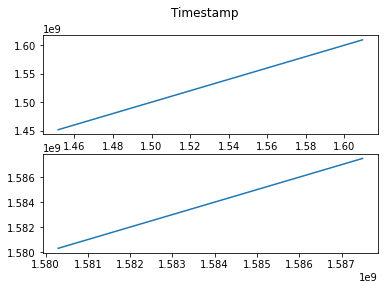

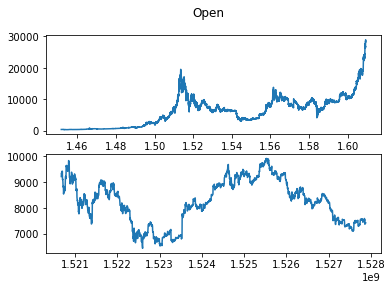

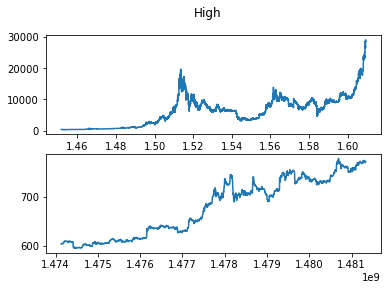

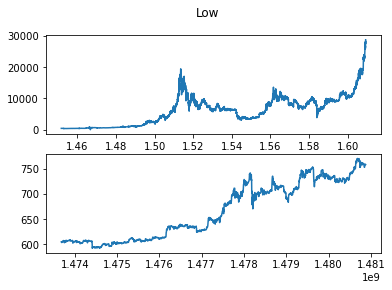

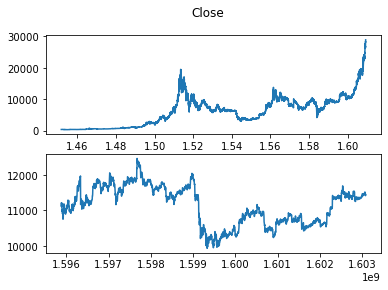

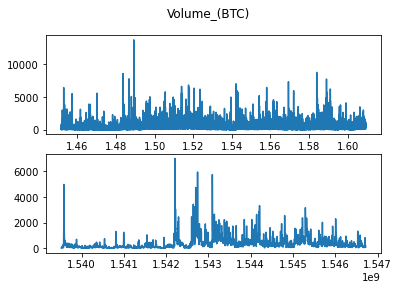

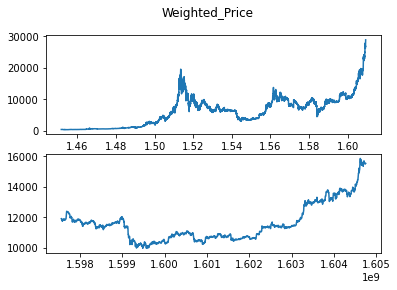

In [9]:
ZOOM_IN_SECTION_LEN = 2000

# Data summary and visualization
print("Original price data shape: ", prices_tensor.shape)
print("Time condensed price data shape: ", condensed_prices_tensor.shape)

for col_name in col_i:
    ind = col_i[col_name]
    x = condensed_prices_tensor[:, 0] # Time
    y = condensed_prices_tensor[:, ind]
    
    # Random section for zoomed in view
    rand_sec_i = random.randint(0, len(condensed_prices_tensor) - ZOOM_IN_SECTION_LEN)

    fig, axs = plt.subplots(2)
    fig.suptitle(col_name)
    axs[0].plot(x, y)
    axs[1].plot(x[rand_sec_i:rand_sec_i+ZOOM_IN_SECTION_LEN], y[rand_sec_i:rand_sec_i+ZOOM_IN_SECTION_LEN])

    mini = torch.min(condensed_prices_tensor[:,ind]).item()
    maxi = torch.max(condensed_prices_tensor[:,ind]).item()
    mean = torch.mean(condensed_prices_tensor[:,ind]).item()
    std = torch.std(condensed_prices_tensor[:,ind]).item()

    print(col_name)
    print("Max", col_name, maxi)
    print("Min", col_name, mini)
    print("Mean", col_name, mean)
    print("Standard deviation of", col_name, std)
    print()

In [10]:
# x = condensed_prices_tensor[32088:34279, 0] # Time
# y = condensed_prices_tensor[32088:34279:, col_i["Weighted_Price"]]

# fig, axs = plt.subplots(1)
# fig.suptitle(col_name)
# axs.plot(x, y)


Max 138.46392822265625
Min -156.2726593017578
Mean 0.12326827645301819
Standard deviation 7.388965606689453
percentile_lowest -2.913989162445068
percentile_lower -0.5698653101921084
percentile_higher 0.9224974632263184
percentile_highest 3.3872734069824215


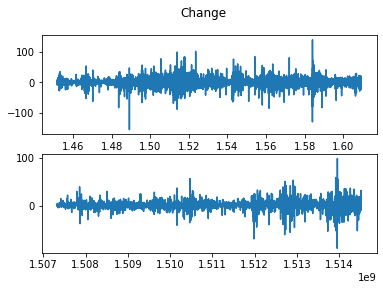

In [11]:
# Convert price to change in price in one thousanth
price_change = (condensed_prices_tensor[1:, col_i["Weighted_Price"]] - condensed_prices_tensor[:-1, col_i["Weighted_Price"]]) / condensed_prices_tensor[:-1, col_i["Weighted_Price"]]
price_change *= 1000

mini = torch.min(price_change).item()
maxi = torch.max(price_change).item()
mean = torch.mean(price_change).item()
std = torch.std(price_change).item()
percentile_lowest = np.percentile(price_change.numpy(), 20).item()
percentile_lower = np.percentile(price_change.numpy(), 40).item()
percentile_higher = np.percentile(price_change.numpy(), 60).item()
percentile_highest = np.percentile(price_change.numpy(), 80).item()

print("Max", maxi)
print("Min", mini)
print("Mean", mean)
print("Standard deviation", std)
print("percentile_lowest", percentile_lowest)
print("percentile_lower", percentile_lower)
print("percentile_higher", percentile_higher)
print("percentile_highest", percentile_highest)

time_x = condensed_prices_tensor[1:, 0]
price_change_y = price_change
section_start = random.randint(0, len(price_change) - ZOOM_IN_SECTION_LEN)

fig, axs = plt.subplots(2)
fig.suptitle('Change')
axs[0].plot(time_x, price_change_y)
axs[1].plot(time_x[section_start:section_start+ZOOM_IN_SECTION_LEN], price_change_y[section_start:section_start+ZOOM_IN_SECTION_LEN])


In [12]:
# Checking for nan data
assert(torch.sum(price_change != price_change) == 0)

In [13]:
# Convert candle stat to percentage of vwap
candle_stats = condensed_prices_tensor[1:, 1:5] / condensed_prices_tensor[1:, col_i["Weighted_Price"]].reshape(-1, 1)

In [14]:
# Normalize volume count
volumes = condensed_prices_tensor[1:, col_i["Volume_(BTC)"]]
mean_vol = torch.mean(volumes)
std_vol = torch.std(volumes)
volumes = (volumes - mean_vol) / std_vol
volumes = volumes.reshape(-1, 1)

In [15]:
# # Normalize
# price_change = (price_change - mean) / std

# mini = torch.min(price_change).item()
# maxi = torch.max(price_change).item()
# mean = torch.mean(price_change).item()
# std = torch.std(price_change).item()

# print("Max", maxi)
# print("Min", mini)
# print("Mean", mean)
# print("Standard deviation", std)

# price_change = torch.cat([price_change.unsqueeze(1), condensed_prices_tensor[1:, 2].unsqueeze(1)], dim=1)

# time_x = condensed_prices_tensor[1:, 0]
# price_change_y = price_change[:, 0]
# volume_y = price_change[:, 1] 
# section_start = random.randint(0, len(price_change) - DISPLAY_SECTION_LEN)

# fig, axs = plt.subplots(4)
# fig.suptitle('Change')
# axs[0].plot(time_x, price_change_y)
# axs[1].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], price_change_y[section_start:section_start+DISPLAY_SECTION_LEN])
# axs[2].plot(time_x, volume_y)
# axs[3].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], volume_y[section_start:section_start+DISPLAY_SECTION_LEN])


In [16]:
price_change = price_change.reshape(-1, 1)

In [17]:
# Slap all features together!
# Open, High, Low, Close, Volume, Price change
# data = torch.cat([candle_stats, volumes, price_change], dim=1)
data = torch.cat([price_change], dim=1)
data[:20]

tensor([[-3.0673],
        [ 1.2295],
        [ 4.1267],
        [ 4.4184],
        [ 2.1721],
        [-6.6283],
        [ 6.1582],
        [-5.6449],
        [-1.1174],
        [-1.6460],
        [ 2.5797],
        [ 1.5442],
        [-9.2094],
        [ 1.1764],
        [ 7.1102],
        [ 1.1286],
        [-0.5564],
        [ 0.2024],
        [-0.1429],
        [ 0.1902]])

In [18]:
# Make input time serie data and target time serie data tensor 
num_data = (len(data) - LEN_ENCODE_SERIE - LEN_DECODE_SERIE) // LEN_DECODE_SERIE + 1

X_shape = (num_data, LEN_ENCODE_SERIE, len(data[0]))
y_shape = (num_data, LEN_DECODE_SERIE)

X, y = torch.empty(X_shape), torch.empty(y_shape)

for i in range(num_data):
    start = i * LEN_DECODE_SERIE
    X[i] = data[start:start+LEN_ENCODE_SERIE]
    y[i] = data[start+LEN_ENCODE_SERIE:start+LEN_ENCODE_SERIE+LEN_DECODE_SERIE, -1] # Price is last feature


In [19]:
print("Encode time serie data shape:", X_shape)
print("Decode time serie data shape:", y_shape)
print("Training X:\n", X[:30])
print("Training y:\n", y[:30])

Encode time serie data shape: (43799, 24, 1)
Decode time serie data shape: (43799, 1)
Training X:
 tensor([[[-3.0673e+00],
         [ 1.2295e+00],
         [ 4.1267e+00],
         [ 4.4184e+00],
         [ 2.1721e+00],
         [-6.6283e+00],
         [ 6.1582e+00],
         [-5.6449e+00],
         [-1.1174e+00],
         [-1.6460e+00],
         [ 2.5797e+00],
         [ 1.5442e+00],
         [-9.2094e+00],
         [ 1.1764e+00],
         [ 7.1102e+00],
         [ 1.1286e+00],
         [-5.5643e-01],
         [ 2.0240e-01],
         [-1.4289e-01],
         [ 1.9020e-01],
         [ 2.4915e+00],
         [-1.4679e+00],
         [ 1.1387e+00],
         [ 2.4285e+00]],

        [[ 1.2295e+00],
         [ 4.1267e+00],
         [ 4.4184e+00],
         [ 2.1721e+00],
         [-6.6283e+00],
         [ 6.1582e+00],
         [-5.6449e+00],
         [-1.1174e+00],
         [-1.6460e+00],
         [ 2.5797e+00],
         [ 1.5442e+00],
         [-9.2094e+00],
         [ 1.1764e+00],
         [ 

In [20]:
torch.save(X, "./../X.pt")
torch.save(y, "./../y.pt")